In [1]:
import osrs_GE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import seaborn as sns

from osrs_GE import elliptic_paraboloid_loss as eploss

from sklearn.metrics import confusion_matrix


#### To-do
- Algorithmic way of determining return thresholds for classification?
    - Should be solely based off of some trailing vol ema or updated every x days/intervals

In [2]:
# dragonfire shield
item_id = 11284
freq = '6h'


item_name = osrs_GE.item_name_from_id(item_id)
df = osrs_GE.read_item_master_file(item_id,freq)
df = osrs_GE.compute_VWAP(df)
df['simpRet_y'] = df['VWAP'].shift(-1)/df['VWAP'] - 1
df.head()

File read successfully for Master Files/items/master_file_11284_6h.csv


,timestamp,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,VWAP,simpRet_y
date,,,,,,,
2024-06-10 12:00:00,1718020800,3242010,3204864,266,211,3.225579e+06,-0.006633
2024-06-10 18:00:00,1718042400,3220588,3182215,383,286,3.204183e+06,-0.047092
2024-06-11 00:00:00,1718064000,3072818,3027371,304,229,3.053292e+06,0.000898
2024-06-11 06:00:00,1718085600,3070790,3031874,203,124,3.056033e+06,0.005086
2024-06-11 12:00:00,1718107200,3090983,3048734,226,192,3.071577e+06,-0.003957


In [3]:
# create train test split
train_idx = int(.7*df.index.shape[0])
train_dt = df.index[train_idx]

print(train_dt)

lagged_rets = 5
RSI_window = 8
MACD_short = 2
MACD_long = 8

max_window = int(np.ceil(max(lagged_rets,RSI_window,MACD_long)/(4*(freq=='6h') + 1*(freq=='24h'))))

CTI = osrs_GE.compute_CTI(interval=freq)
CTI_ret = CTI/CTI.shift(1) - 1


DF = osrs_GE.compute_features(df,lagged_rets=lagged_rets,RSI_window=RSI_window,
                             MACD_short=MACD_short,
                             MACD_long=MACD_long)


DF['CTI_ret1'] = CTI_ret
DF = DF.dropna()


# take out 2024-10-01 (servers went down)
# subsequently any features computed that involved that day removed as well
# could be a better way to handle this, but hopefully this minimizes damage from
# the contamination of the bad day

bad_date_fltr = (DF.index > DF.loc['2024-10-01'].index[0] + pd.Timedelta(max_window,'D')) | (DF.index<'2024-10-01')
DF = DF[bad_date_fltr]

df_tr = DF[DF.index < train_dt]
train_length = df_tr.shape[0]

print(df_tr.shape)
#print(df_te.shape)

2024-09-11 12:00:00
(364, 15)


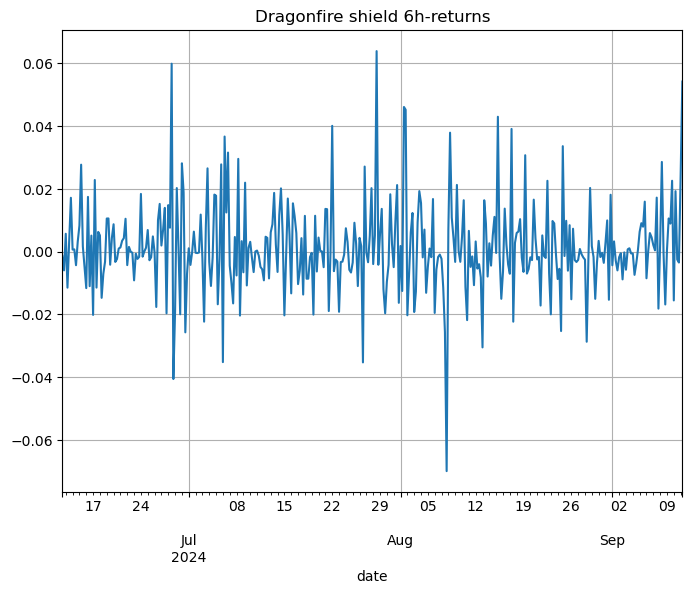

In [4]:
df_tr['simpRet_y'].plot(figsize=(8,6))
plt.title("{0} {1}-returns".format(item_name,freq))
plt.grid()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_tr['simpRet_y'])
print('t-stat:{:.3f}'.format(adf_test[0]))
print('p-value:{:.4f}'.format(adf_test[1]))
print('lags:{}'.format(adf_test[2]))

t-stat:-16.651
p-value:0.0000
lags:1


In [6]:
from pmdarima.arima import auto_arima
auto_res = auto_arima(df_tr['simpRet_y'],seasonal=False,trace=True,max_p=15,max_q=15)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2055.663, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2047.404, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2048.339, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2049.851, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2054.988, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2056.802, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2052.696, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2058.263, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-2057.268, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2055.038, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2061.416, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2049.992, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2061.021, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2059.719, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0

In [7]:
print(auto_res.order)
p,d,q = auto_res.order

(3, 0, 1)


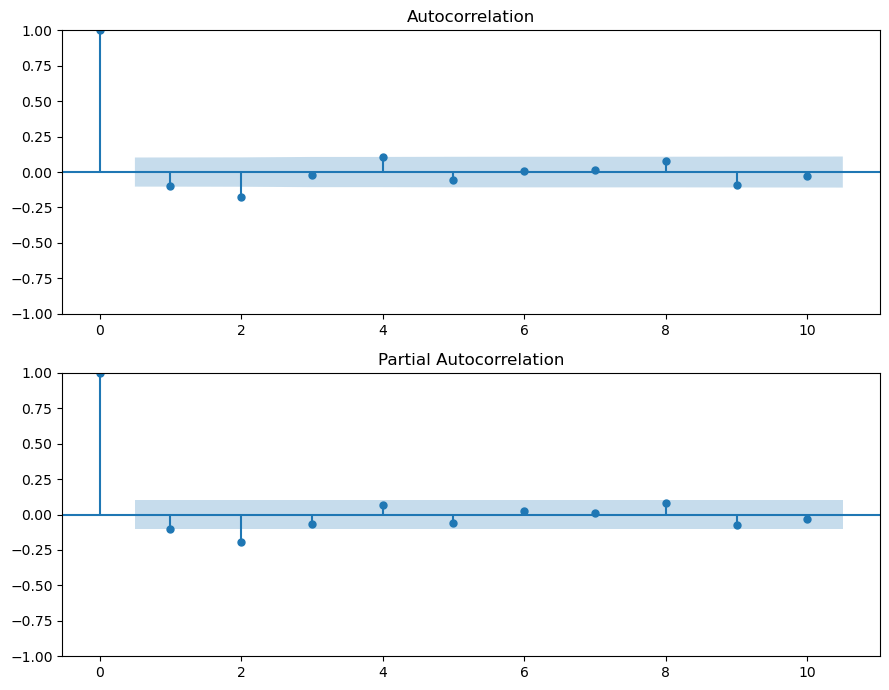

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(df_tr['simpRet_y'],lags=10, ax=ax[0])
plot_pacf(df_tr['simpRet_y'],lags=10, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

What features to include in forecasting price?
- order imbalance (+ lags)
- lagged returns
- TA indicators
  - RSI
  - MACD
  - SMA
  - LMA

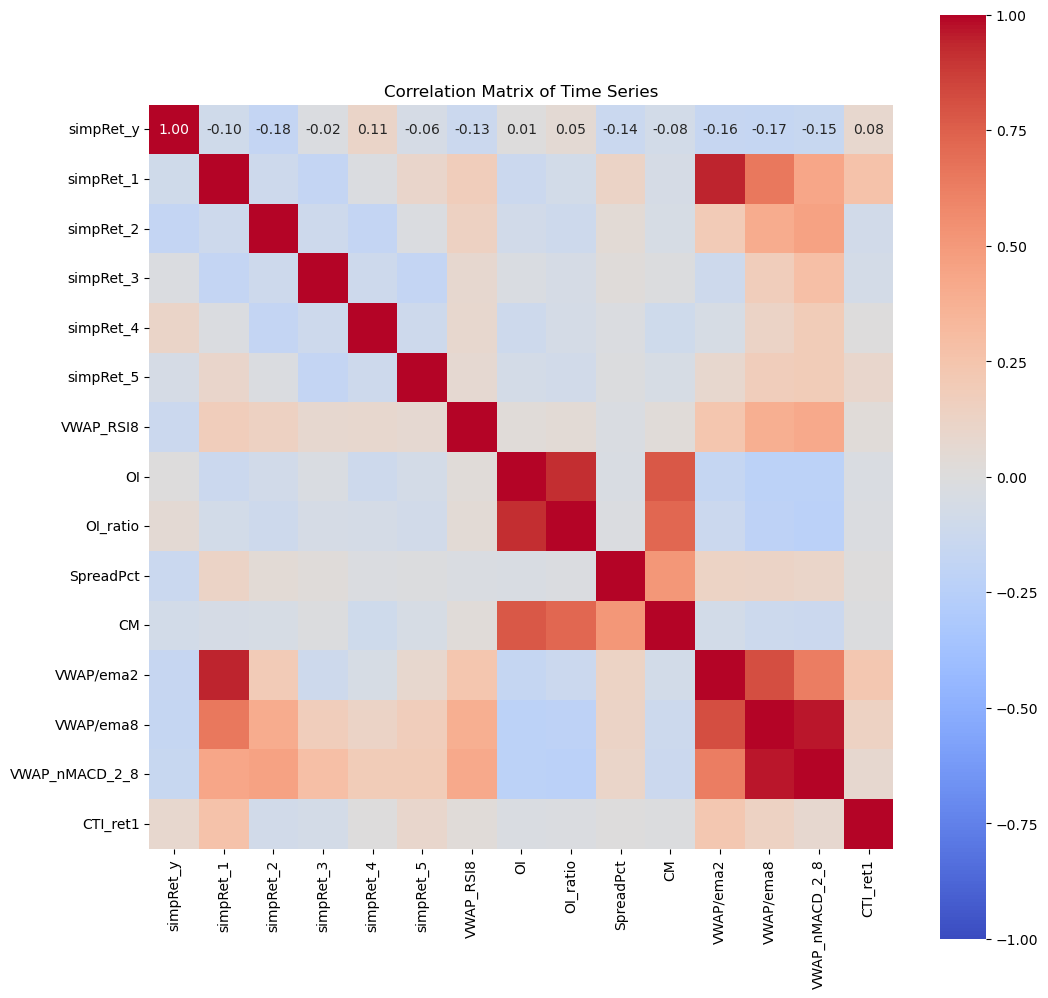

In [9]:
corr_matrix = df_tr.corr()

plt.figure(figsize=(12,12))

sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',square=True,vmin=-1,vmax=1)

plt.title('Correlation Matrix of Time Series')
plt.show()

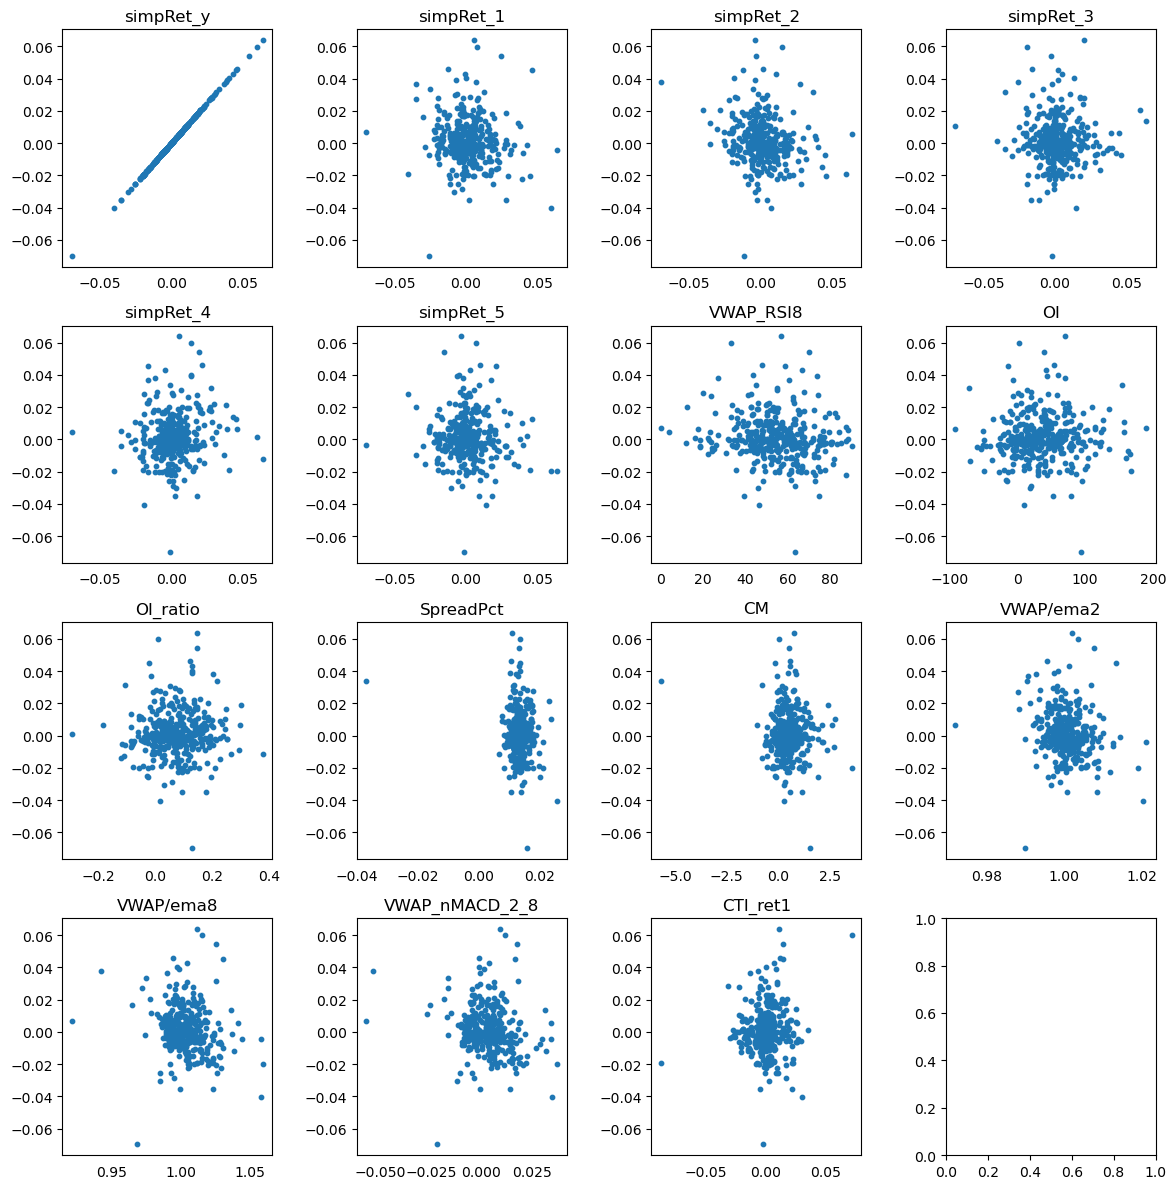

In [10]:
figs,axs = plt.subplots(int(np.ceil(df_tr.shape[1]/4)),4,figsize=(12,12))

ct = 0
for col in df_tr.columns:
    ax = axs[ct//4,ct%4]
    ax.tick_params(bottom=False)
    ax.scatter(df_tr[col],df_tr['simpRet_y'],s=10)
    ax.set_title(col)
    ct += 1
    
figs.tight_layout()
plt.show()

# Return forecasting

## Feature selection for linear models

In [11]:
## Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

X = df_tr.drop('simpRet_y',axis=1).values
y = df_tr['simpRet_y'].values

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [12]:
names=df_tr.drop("simpRet_y", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['simpRet_1' 'simpRet_2' 'simpRet_3' 'simpRet_4' 'simpRet_5' 'VWAP_RSI8'
 'OI' 'OI_ratio' 'SpreadPct' 'CM' 'VWAP/ema2' 'VWAP/ema8' 'VWAP_nMACD_2_8'
 'CTI_ret1']


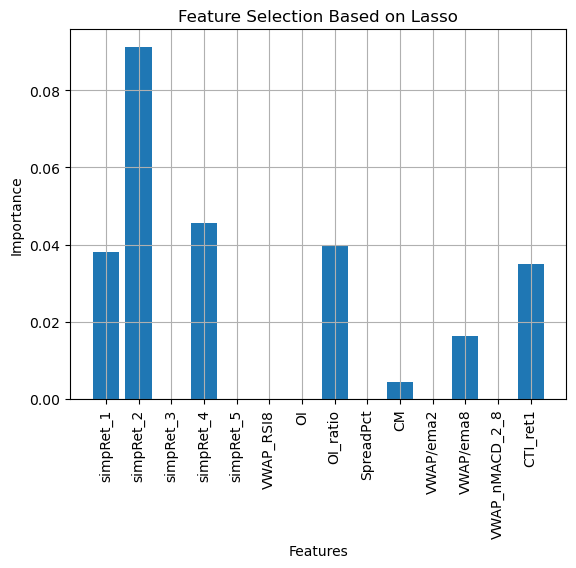

In [13]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [14]:
# Subsetting the features that are relevant.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, 'simpRet_y')
print("Selected Columns: {}".format(feature_subset))

df_tr_new = df_tr[feature_subset]

Selected Feature Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema8'
 'CTI_ret1']
Selected Columns: ['simpRet_1' 'simpRet_2' 'simpRet_4' 'OI_ratio' 'CM' 'VWAP/ema8'
 'CTI_ret1' 'simpRet_y']


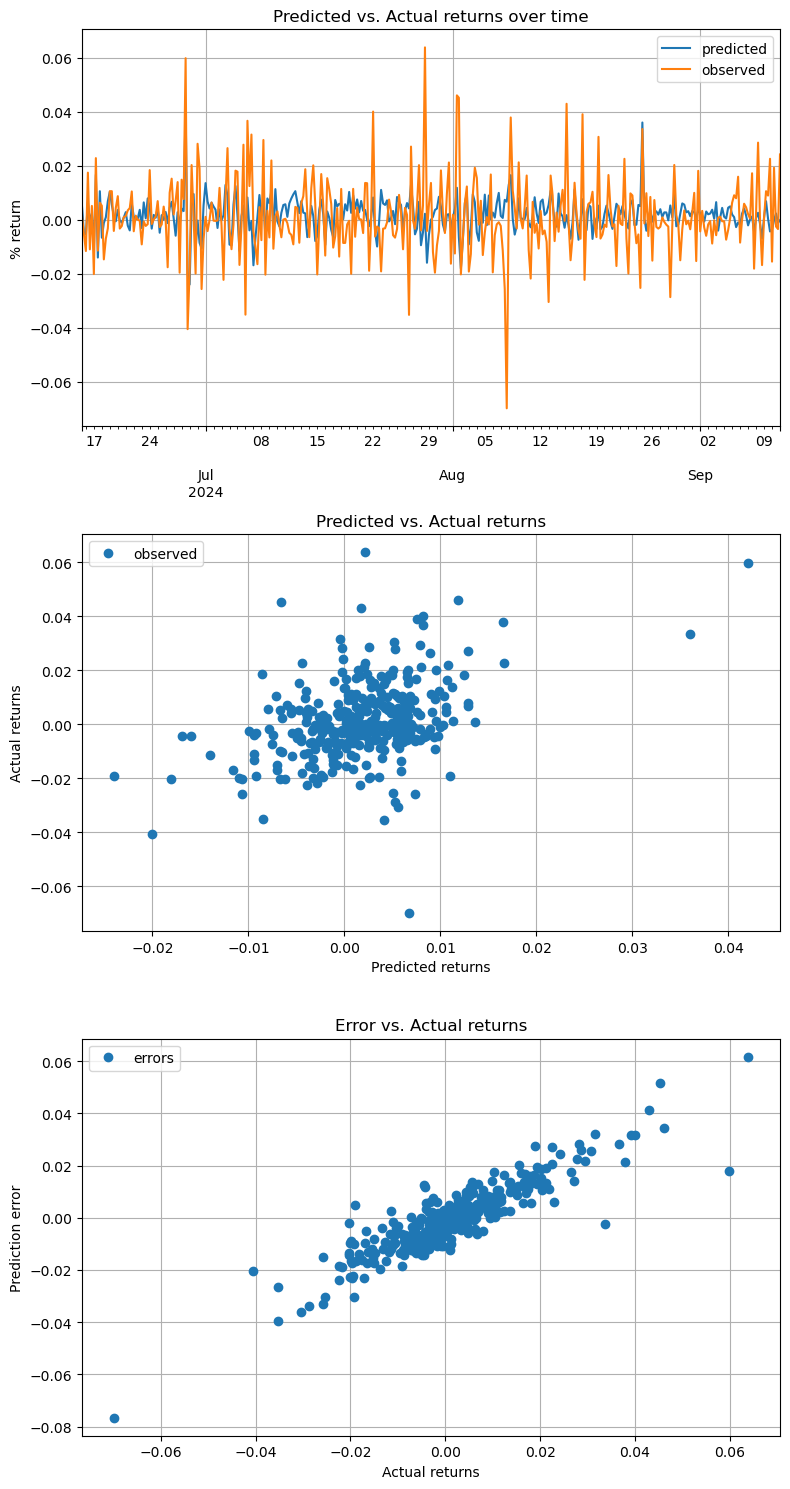

Mean EPLoss:  0.0008975581676861791
MSE:  0.00017136400234724308


In [15]:
lr_train_res = osrs_GE.iterative_testing(df_tr_new,'simpRet_y',model=LinearRegression())

#### Benchmarking with an ARIMA model

In [16]:
start_point = 10

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

arima_result = osrs_GE.ARIMA_CV_SCORE(df_tr_new['simpRet_y'],order=(p,d,q),start_point=start_point,
                                     custom_scorer=eploss)

In [17]:
print("ARIMA mean EPloss: ",arima_result['custom_scores'].mean())
print("ARIMA MSE: ",(arima_result['errors']**2).mean())

ARIMA mean EPloss:  0.0011766898174146569
ARIMA MSE:  0.00022893285350513728


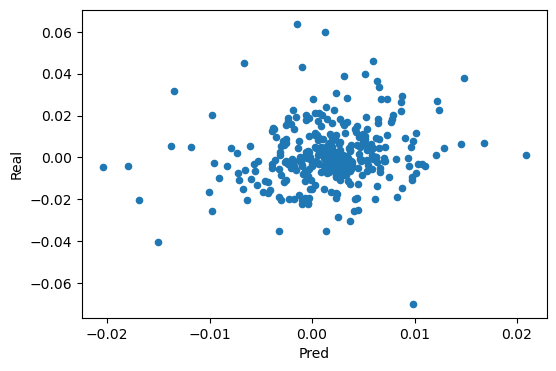

In [18]:
arima_result['ret_df'].plot(x='Pred',y='Real',kind='scatter',figsize=(6,4))
plt.show()

### Polynomial feature engineering?

Clearly the residuals suggest that our model is not capturing a more complex underlying relationship between returns and our features

In [19]:
from sklearn.preprocessing import PolynomialFeatures
pd.options.mode.chained_assignment = None  # default='warn'

df_tr2 = DF[DF.index < train_dt]

df2 = DF.copy()

X = df_tr2.drop(['simpRet_y'],axis=1).values
y = df_tr2['simpRet_y'].values

poly = PolynomialFeatures(degree=2,include_bias=False)
X_poly = poly.fit_transform(X)

feat_names = poly.get_feature_names_out(input_features=df_tr2.drop(['simpRet_y'],axis=1).columns)

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_poly, y)
alpha = lasso_cv.best_params_['alpha']
print("Best Params {}".format(lasso_cv.best_params_))

# calling the model with the best parameter
lasso1 = Lasso(alpha=lasso_cv.best_params_['alpha'])
lasso1.fit(X_poly, y)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# Subsetting the features that are relevant.
feature_subset2=np.array(feat_names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset2))

# Adding the target to the list of feaatures. 
feature_subset2=np.append(feature_subset2, 'simpRet_y')

for col in feature_subset2:
    if col not in df_tr2:
        ## squared term
        if '^2' in col:
            df_tr2[col] = df_tr2[col[:-2]]**2
            df2[col] = df2[col[:-2]]**2
            
        ## interaction term
        else:
            col1,col2 = col.split(' ')
            df_tr2[col] = df_tr2[col1]*df_tr2[col2]
            df2[col] = df2[col1]*df2[col2]

            
df_tr2_new = df_tr2[feature_subset2]
df2_new = df2[feature_subset2]

Best Params {'alpha': 1e-05}
Selected Feature Columns: ['simpRet_1 VWAP_RSI8' 'simpRet_2 VWAP_RSI8' 'simpRet_2 OI'
 'simpRet_3 VWAP_RSI8' 'simpRet_3 OI' 'simpRet_5 OI'
 'VWAP_RSI8 VWAP_nMACD_2_8' 'VWAP_RSI8 CTI_ret1' 'OI VWAP_nMACD_2_8'
 'CM^2']


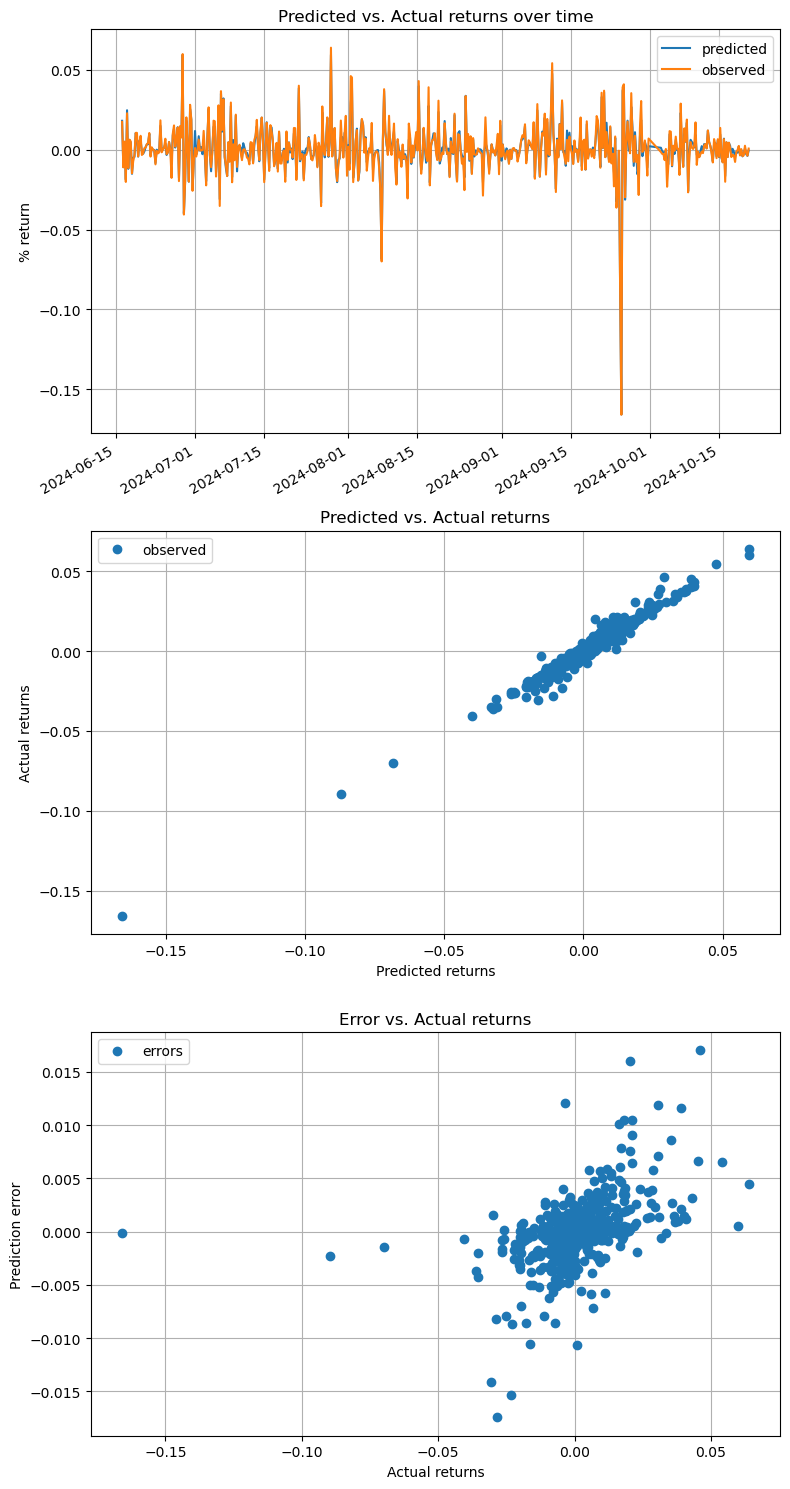

Mean EPLoss:  0.00017673215660300476
MSE:  1.064040174372001e-05


In [20]:
lr2_test_res = osrs_GE.iterative_testing(df2_new,'simpRet_y',LinearRegression(),start_point=10,decay_weight=0.8)

## Reframing the problem as classification for an investing strategy

In [21]:
trading_results = {}

In [22]:
# defining the % return threshold for trading strategy
# buy when pred > .005, sell when pred < -.0075

q_b , q_s = .005,-.0075

(1.0*(df_tr['simpRet_y'] > q_b) - (df_tr['simpRet_y'] < q_s)).value_counts()

simpRet_y
 0.0    179
 1.0    116
-1.0     69
Name: count, dtype: int64

### revisiting linear regression as a classifier

#### first-order terms

In [23]:
lr_train_res['signal'] = 1.0*(lr_train_res['predicted']>q_b) - (lr_train_res['predicted'] < q_s)

lr_train_res = lr_train_res.join(df['VWAP'])
lr_train_res = lr_train_res.rename({'VWAP':'VWAP_trade'},axis=1)

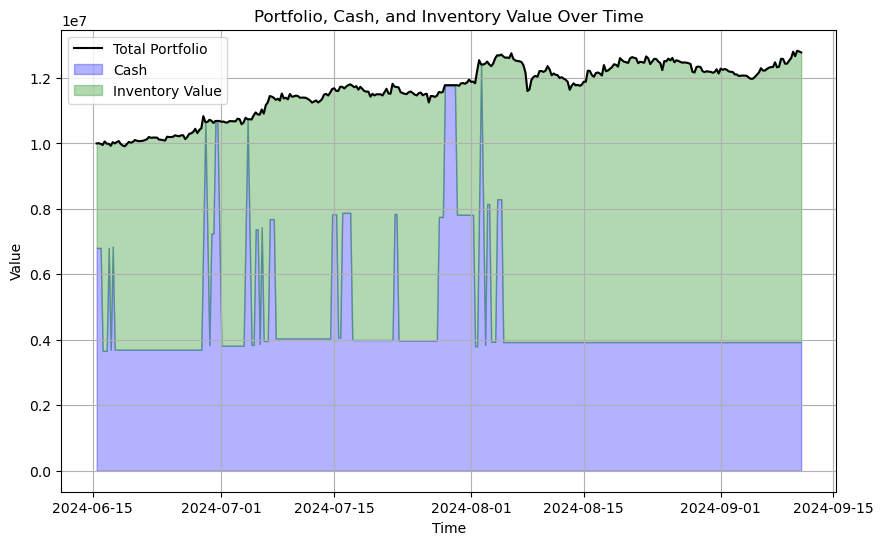

            inventory         stack  total_portfolio          cash  \
2024-09-11        2.0  3.929647e+06     1.277855e+07  3.929647e+06   

            inventory_value  
2024-09-11     8.848906e+06  


In [24]:
trading_results['lin_reg'] = osrs_GE.trading_strategy_pnler(lr_train_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg'].tail(1))

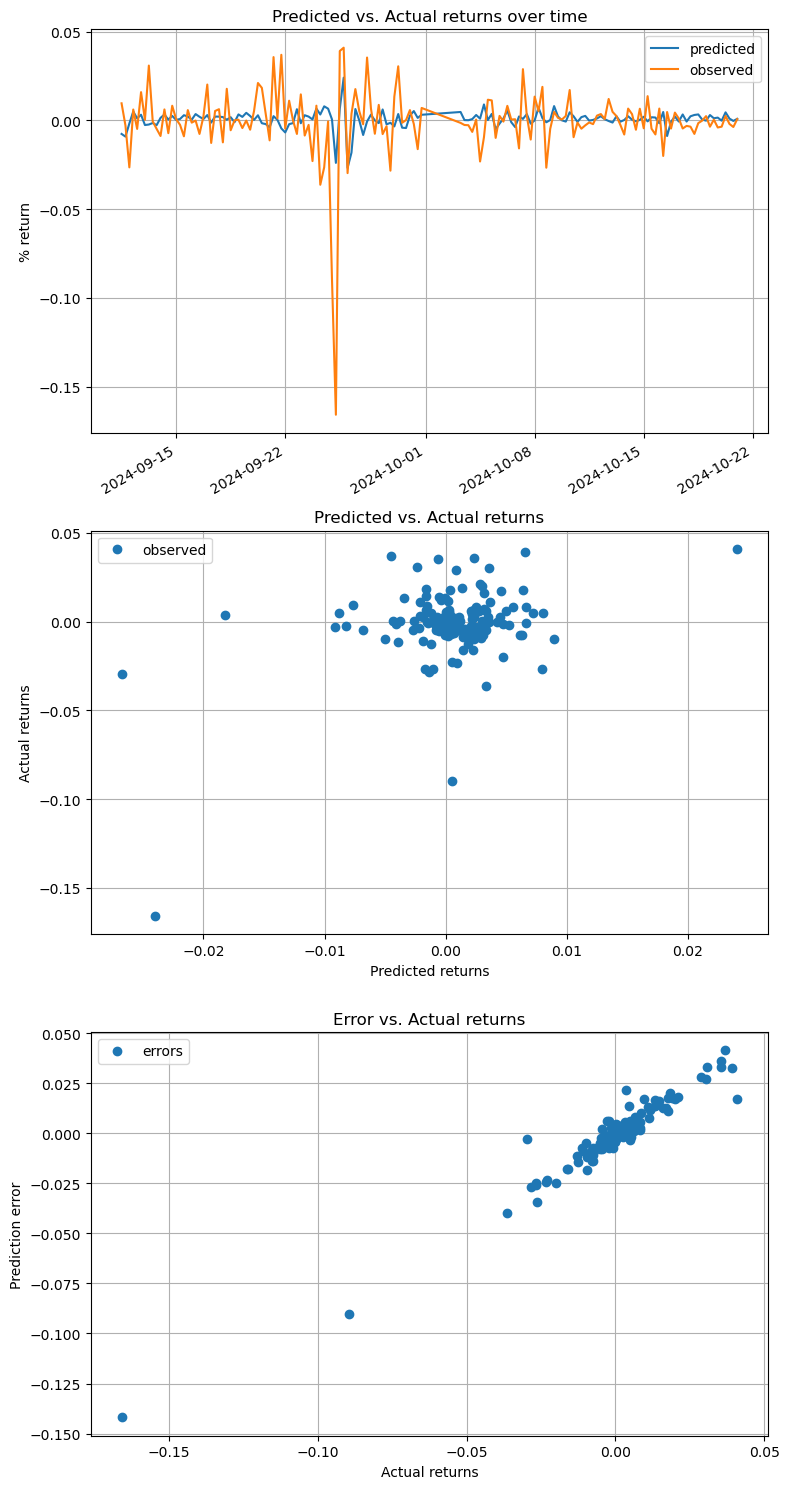

Mean EPLoss:  0.001789936659195201
MSE:  0.00034551633358454657


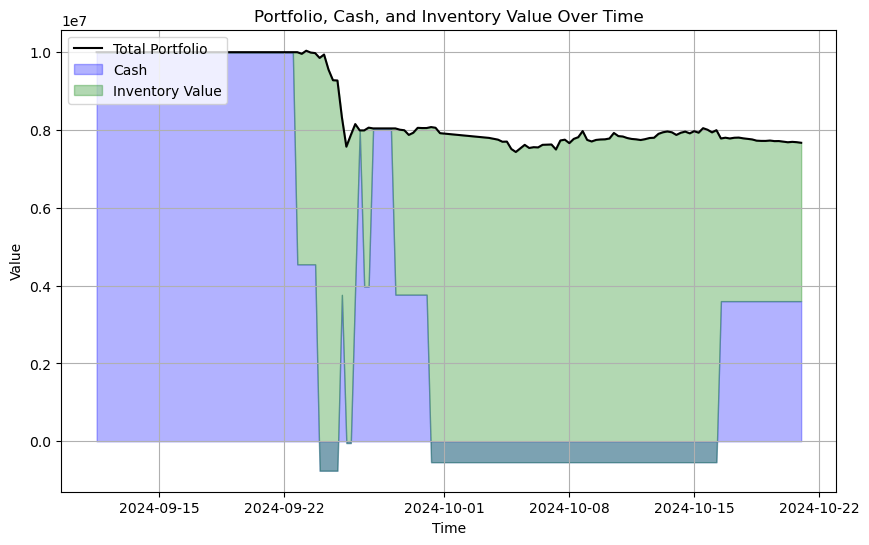

inventory          1.000000e+00
stack              3.601340e+06
total_portfolio    7.671814e+06
cash               3.601340e+06
inventory_value    4.070474e+06
Name: 2024-10-21 00:00:00, dtype: float64


In [25]:
df_copy = DF[feature_subset]
lr_test_res = osrs_GE.iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = train_length)

lr_test_res['signal'] = 1.0*(lr_test_res['predicted']>q_b) - (lr_test_res['predicted'] < q_s)
lr_test_res = lr_test_res.join(df['VWAP']).rename({'VWAP':'VWAP_trade'},axis=1)

trading_results['lin_reg_test'] = osrs_GE.trading_strategy_pnler(lr_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg_test'].iloc[-1])

#lr = osrs_GE.iterative_testing(df_copy,'simpRet_y',model=LinearRegression(),start_point = 10)

#### interaction terms + sample weighting

In [26]:
lr2_test_res['signal'] = 1.0*(lr2_test_res['predicted'] > q_b) - (lr_train_res['predicted']<q_s)
lr2_test_res = lr2_test_res.join(df['VWAP']).rename({'VWAP':'VWAP_trade'},axis=1)
trading_results['lin_reg2'] = osrs_GE.trading_strategy_pnler(lr2_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['lin_reg2'].tail(1))


### revisiting ARIMA

In [28]:
arima_result['ret_df']['signal'] = 1.0*(arima_result['ret_df']['Pred'] > q_b) - 1.0*(arima_result['ret_df']['Pred'] < q_s)
arima_result['ret_df'] = arima_result['ret_df'].join(df['VWAP']).rename({'VWAP':'VWAP_trade'},axis=1)

trading_results['arima_train'] = osrs_GE.trading_strategy_pnler(arima_result['ret_df'],
                                                                max_allowable=2,
                                                                start_stack = 10e6)
print(trading_results['arima_train'].iloc[-1])

In [31]:
arima_test = osrs_GE.ARIMA_CV_SCORE(df.copy().dropna()['simpRet_y'],order=(p,d,q),start_point = train_length,custom_scorer=eploss)

print("ARIMA order: ({0},{1},{2})".format(p,d,q))
print("ARIMA mean EPloss: ",arima_test['custom_scores'].mean())
print("ARIMA MSE: ",(arima_test['errors']**2).mean())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a 

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a 

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a 

In [33]:
arima_test_res = arima_test['ret_df']

arima_test_res['signal'] = 1.0*(arima_test_res['Pred']>q_b) - (arima_test_res['Pred'] < q_s)
arima_test_res = arima_test_res.join(df['VWAP']).rename({'VWAP':'VWAP_trade'},axis=1)

trading_results['arima_test_({0},{1},{2})'.format(p,d,q)] = osrs_GE.trading_strategy_pnler(arima_test_res,max_allowable=2,start_stack = 10e6)
print(trading_results['arima_test_({0},{1},{2})'.format(p,d,q)].iloc[-1])

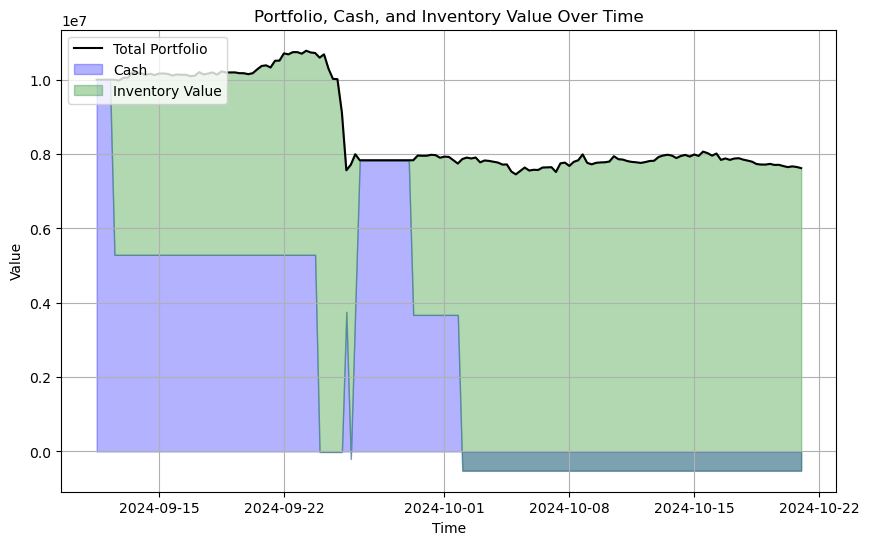

inventory          2.000000e+00
stack             -5.188152e+05
total_portfolio    7.622132e+06
cash              -5.188152e+05
inventory_value    8.140947e+06
Name: 2024-10-21 00:00:00, dtype: float64


### Random Forest

In [35]:
def _scorer(y_true,y_pred,neut = 1,opp=3):
    diff = np.abs(y_true - y_pred)
    res = 0*(diff == 0) - neut*(diff == 1) - opp*(diff > 1)
    return res.mean()
    
from sklearn.metrics import make_scorer

scorer = make_scorer(_scorer)

In [36]:
from sklearn.ensemble import RandomForestClassifier

print(q_b, q_s)
df_tr['signal_y'] = 1*(df_tr['simpRet_y']>q_b) - (df_tr['simpRet_y']<q_s)

df_tr2 = df_tr.copy().drop('simpRet_y',axis=1)

param_grid = {
    'n_estimators':[50,80,100,150,200,250,300],
    'max_depth':[3,4,5,6,7]
}

X = df_tr2.drop('signal_y',axis=1).values
y = df_tr2['signal_y'].values


rfc_cv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,scoring=scorer)
rfc_cv.fit(X,y)

print(rfc_cv.best_params_)

0.005 -0.0075
{'max_depth': 3, 'n_estimators': 80}


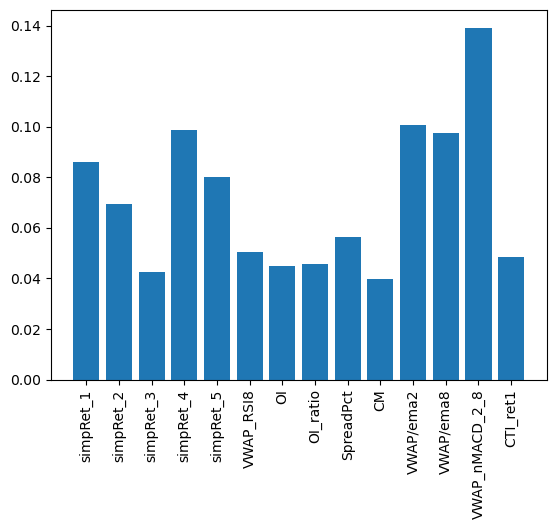

Overall Accuracy: 0.7522
Buy/Sell (ignore hold) Accuracy: 0.9891
Buy Precision: 0.5463
Sell Precision: 0.4923
Mean EPLoss:  1.446064139941691
MSE:  0.2565597667638484


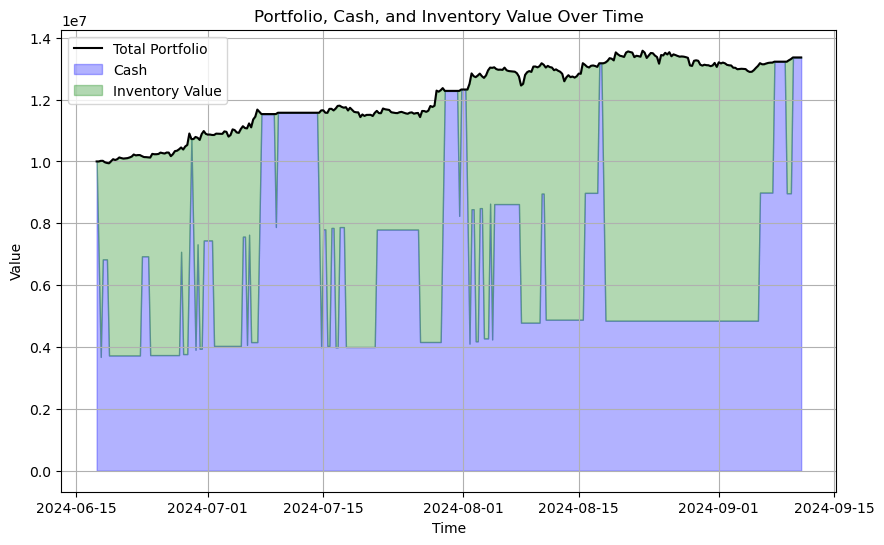

In [37]:
rfc = RandomForestClassifier(n_estimators = rfc_cv.best_params_['n_estimators'],
                                   max_depth = rfc_cv.best_params_['max_depth'],
                                   random_state = 8)
rfc.fit(X,y)
yhat = rfc.predict(X)

plt.bar(x = df_tr2.drop('signal_y',axis=1).columns,height = rfc.feature_importances_)
plt.xticks(rotation=90)
plt.show()

rfc_tr = RandomForestClassifier(n_estimators = rfc_cv.best_params_['n_estimators'],
                                   max_depth = rfc_cv.best_params_['max_depth'],
                                   random_state = 8)

rfc_tr_preds = osrs_GE.iterative_testing(df_tr2,'signal_y',model=rfc_tr,start_point=df_tr2.columns.shape[0]+5,
                                        plot=False).join(df['VWAP']).rename({'VWAP':'VWAP_trade','predicted':'signal'},axis=1)

trading_results['rfc_train'] = osrs_GE.trading_strategy_pnler(rfc_tr_preds,max_allowable=2,start_stack = 10e6)

Overall Accuracy: 0.6133
Buy/Sell (ignore hold) Accuracy: 0.7273
Buy Precision: 0.2791
Sell Precision: 0.1333
Mean EPLoss:  2.63
MSE:  0.5066666666666667


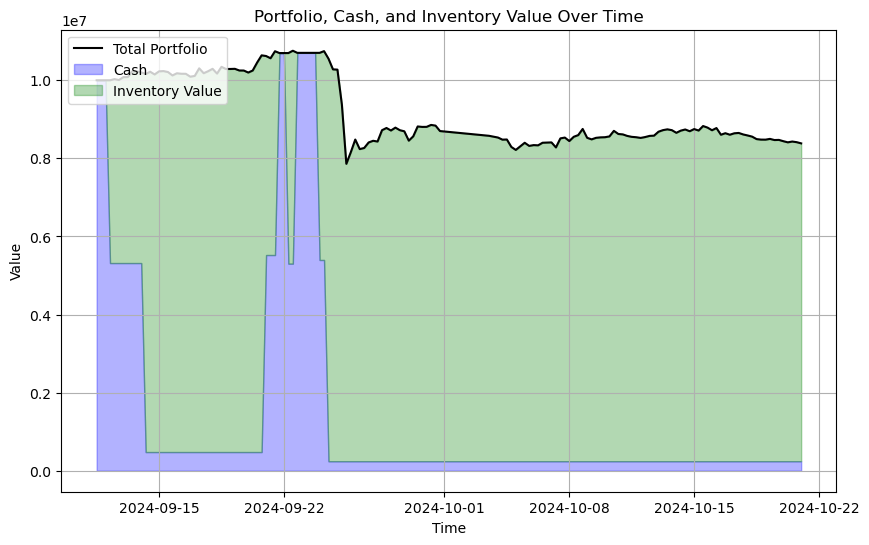

In [39]:
df_te = DF.copy()
df_te['signal_y'] = 1*(df_te['simpRet_y']> q_b) - 1*(df_te['simpRet_y'] < q_s)
df_te[df_tr2.columns]

rfc_te_preds = osrs_GE.iterative_testing(df_te[df_tr2.columns],y_col='signal_y',model=rfc_tr,
                                 start_point = df_tr2.shape[0],plot=False)

rfc_signal_df_te = rfc_te_preds.join(df['VWAP']).rename({'VWAP':'VWAP_trade','predicted':'signal'},axis=1)

trading_results['rfc_test'] = osrs_GE.trading_strategy_pnler(rfc_signal_df_te,max_allowable=2,start_stack = 10e6)

Overall Accuracy: 0.9933
Buy/Sell (ignore hold) Accuracy: 1.0000
Buy Precision: 1.0000
Sell Precision: 0.9667
Mean EPLoss:  0.27416666666666667
MSE:  0.006666666666666667


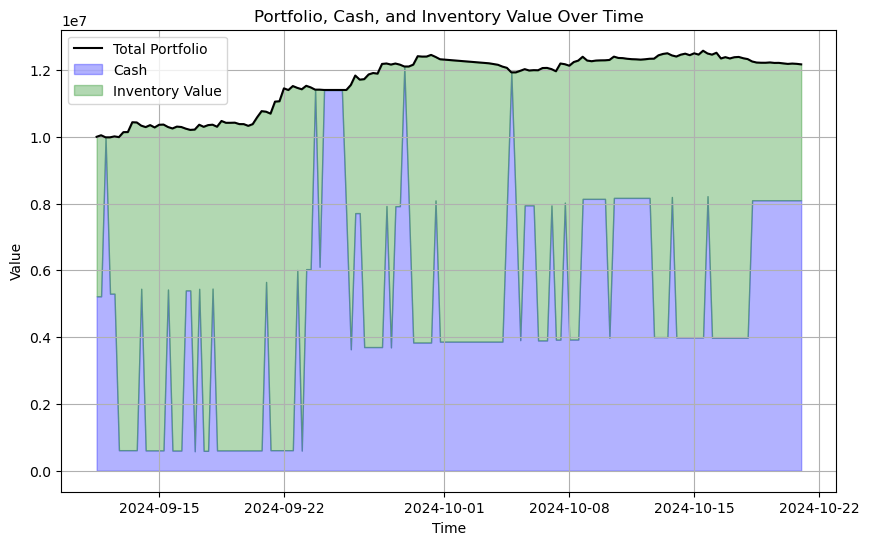

In [40]:
rfc2 = RandomForestClassifier(n_estimators = rfc_cv.best_params_['n_estimators'],
                                   max_depth = rfc_cv.best_params_['max_depth'],
                                   random_state = 8)

X = df_tr2.drop('signal_y',axis=1).values
y = df_tr2['signal_y'].values

rfc2.fit(X,y,sample_weight=osrs_GE.generate_sample_weights(X.shape[0],0.8))

rfc2_te_preds = osrs_GE.iterative_testing(df_te[df_tr2.columns],y_col='signal_y',model=rfc2,
                                 start_point = df_tr2.shape[0],plot=False,decay_weight = 0.8)

rfc2_signal_df_te = rfc2_te_preds.join(df['VWAP']).rename({'VWAP':'VWAP_trade','predicted':'signal'},axis=1)

trading_results['rfc2_test'] = osrs_GE.trading_strategy_pnler(rfc2_signal_df_te,max_allowable=2,start_stack = 10e6)

Overall Accuracy: 1.0000
Buy/Sell (ignore hold) Accuracy: 1.0000
Buy Precision: 1.0000
Sell Precision: 1.0000
Mean EPLoss:  0.2433333333333333
MSE:  0.0


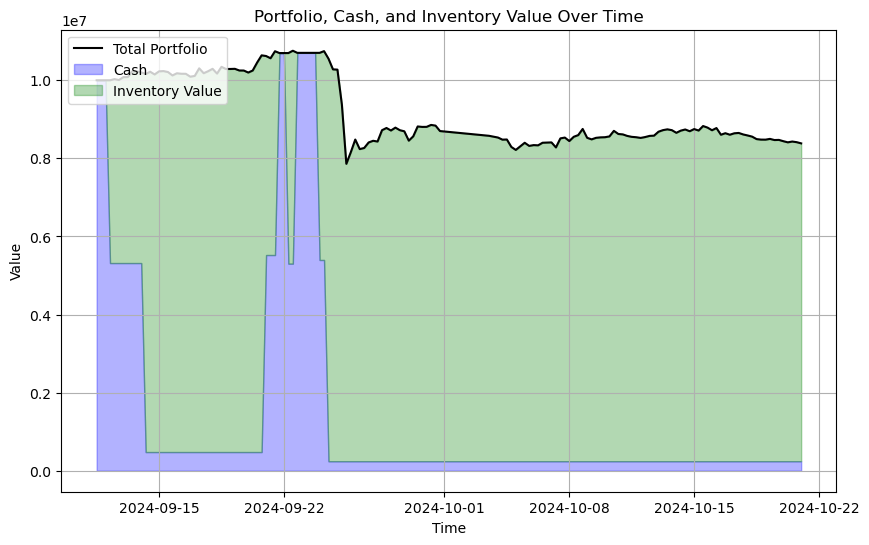

In [43]:
df2_new['signal_y'] = 1*(df2_new['simpRet_y']> q_b) - 1*(df2_new['simpRet_y'] < q_s)
rfc3 = RandomForestClassifier(n_estimators = rfc_cv.best_params_['n_estimators'],
                                   max_depth = rfc_cv.best_params_['max_depth'],
                                   random_state = 8)

rfc3_te_preds = osrs_GE.iterative_testing(df2_new.drop('simpRet_y',axis=1),y_col='signal_y',model=rfc3,
                                 start_point = df_tr2_new.shape[0],plot=False,decay_weight=0.8)

rfc3_signal_df_te = rfc_te_preds.join(df['VWAP']).rename({'VWAP':'VWAP_trade','predicted':'signal'},axis=1)

trading_results['rfc3_test'] = osrs_GE.trading_strategy_pnler(rfc3_signal_df_te,max_allowable=2,start_stack = 10e6)

## SVM